In [1]:
import pandas as pd
import numpy as np
import os
import docx2txt
import docx
import re
import seaborn as sns
sns.set_style('whitegrid')

In [84]:
import pandas as pd
import string
import matplotlib.pyplot as plt
from datetime import datetime
import re
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

tokenizer = RegexpTokenizer(r'\w+') # initialize regex tokenizer
exclude = set(string.punctuation)
en_stop = set(stopwords.words('english'))# create English stop words list
lemma = WordNetLemmatizer()
p_stemmer = PorterStemmer() # Create p_stemmer of class PorterStemmer

def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for raw in doc_set:
        # clean and tokenize document string
        tokens = tokenizer.tokenize(raw.lower())
        # remove stop words and unwanted words from tokens
        stopped_tokens = [i for i in tokens if (i not in en_stop) and (i not in exclude)]
        # stem tokens
        stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts



def print_doc_list(doc_list):
    for i in doc_list:
        print(i)
        print('')
        print('')
    return None

def check_If_reference(string):
    for year in range(2020,1950,-1):
        if '[{}]'.format(year) in string or '({})'.format(year) in string or '{}'.format(year) in string:
            if '“' in string or '‘' in string or "'" in string or 'pp.' in string or '"' in string:
                return True
    return False
 
def debug_print(document):
    for para in document.paragraphs:
        if para.style.name !='Normal':
            print(para.style.name)
            print(para.text)
    return None

def load_up_from_cleaned_speech():
    MPC_speech = pd.read_excel('./scripter/cleaned_dataset/MPC_speech.xlsx')
    file_list = os.listdir("./scripter/cleaned_dataset/Speech_MPC")
    for n,file in enumerate(file_list):
        text_file = open("./scripter/cleaned_dataset/Speech_MPC/{}".format(file), "r").read()
        MPC_speech.loc[MPC_speech['title']==file[:-4],'document_string'] = text_file
    return MPC_speech


def filter_para(paragraph_list):                                  
    paragraph_list = [i for i in paragraph_list if i != '']
    for n in range(len(paragraph_list)-1,-1,-1):
        if 'were present:' in paragraph_list[n]:
            paragraph_list = paragraph_list[:n]
    return paragraph_list

def clean_text(file):
    #file = 'Minutes of the MPC Meeting held on 12 and 13 January 2000_1st.docx'
    document = docx.Document("./scripter/converted_files/{}/{}".format(folder,file))
    Document_list = []   # each element represent one heading (section)
    paragraph_list = []  # each element represent one paragraph in each section
    start_record = False
    force_stop = False

    if sum(['Heading' in para.style.name for para in document.paragraphs])>=2:
        for para in document.paragraphs:
            if 'Heading' in para.style.name and force_stop == False:
                if 'ANNEX:' in para.text and start_record==True:   
                    force_stop = True

                elif start_record == False:
                    paragraph_list.append(para.text)
                    start_record = True

                elif start_record == True: 
                    Document_list.append(filter_para(paragraph_list))
                    paragraph_list = [para.text]

            elif para.style.name in ['List Paragraph','Body Text'] and start_record == True and force_stop == False:
                if len(para.text.split())>=4:
                    paragraph_list.append(re.sub(r'[0-9]+', '',re.sub(r'[^\x00-\x7F]+',' ',para.text.replace('\uf0be','').replace('\t','').replace("\'","'"))))

    Document_list.append(filter_para(paragraph_list))
    try:
        doc2 = []
        for i in Document_list:
            doc2.append(i)
            if 'immediate policy decision' in i[0]:
                break
        Document_list = [i for n,i in enumerate(doc2) if len(i)>=3 or n>=3]
    except:
        Document_list = [i for n,i in enumerate(Document_list) if len(i)>=3 or n>=3]
    return Document_list

def encode_doc_minutes(Document_list):
    return '##NewTopic##'.join(['##NewPara##'.join(i) for i in Document_list])

def decode_doc_minutes(Doc_string):
    return [i.split('##NewPara##') for i in Doc_string.split('##NewTopic##')]

def load_up_from_cleaned_minutes():
    MPC_minutes = pd.read_excel('./scripter/cleaned_dataset/MPC_minutes.xlsx')
    file_list = os.listdir("./scripter/cleaned_dataset/Minutes_MPC")
    for n,file in enumerate(file_list):
        text_file = open("./scripter/cleaned_dataset/Minutes_MPC/{}".format(file), "r").read()
        MPC_minutes.loc[MPC_minutes['title']==file[:-4],'document_string'] = text_file
    return MPC_minutes
def write_file(Document_list,folder,file):
    Word_set = encode_doc_minutes(Document_list)
    text_file = open("./scripter/cleaned_dataset/{}/{}.txt".format(folder,file[:-5]), "w")
    text_file.write(Word_set)
    text_file.close()    
    return None


   
def show_section_name(document_list):
    return [[k[0] for k in i] for i in document_list]

def show_unique_section_name(document_list):
    result = {}
    for i in document_list:
        for k in i:
            if k[0] not in result:
                result[k[0]]=1
            else:
                result[k[0]]+=1
    return {k: v for k, v in sorted(result.items(), key=lambda item: -item[1])}



def rule_for_merge(list_of_names,target_name,document_list):
    new_document_list = document_list.copy()
    list_of_names = list_of_names+[target_name]
    for n,document in enumerate(document_list):
        new_document = []
        merged_paragraph = [target_name]
        for paragraph in document:
            if paragraph[0] not in list_of_names:
                new_document.append(paragraph)
            else:
                merged_paragraph = merged_paragraph + paragraph[1:]
        if merged_paragraph!=[target_name]:
            new_document.append(merged_paragraph)
        new_document_list[n] = new_document
    return new_document_list

def rule_for_replace(dict1,document_list):
    for orignal_name in dict1.keys():
        target_name = dict1[orignal_name]
        for n,document in enumerate(document_list):
            for k,paragraph in enumerate(document):
                if paragraph[0] == orignal_name:
                    document_list[n][k][0]= target_name
    return document_list

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


----
----
# Data Cleaning for MPC speech
##  ignore all the codes belows, jump to next section, this section is data cleaning where i has been saved.

In [3]:
# MPC_speech = pd.read_excel('./scripter/cleaned_dataset/MPC_speech.xlsx')


We could see that 'Normal' style words refer to refference and labels which is not what we what 
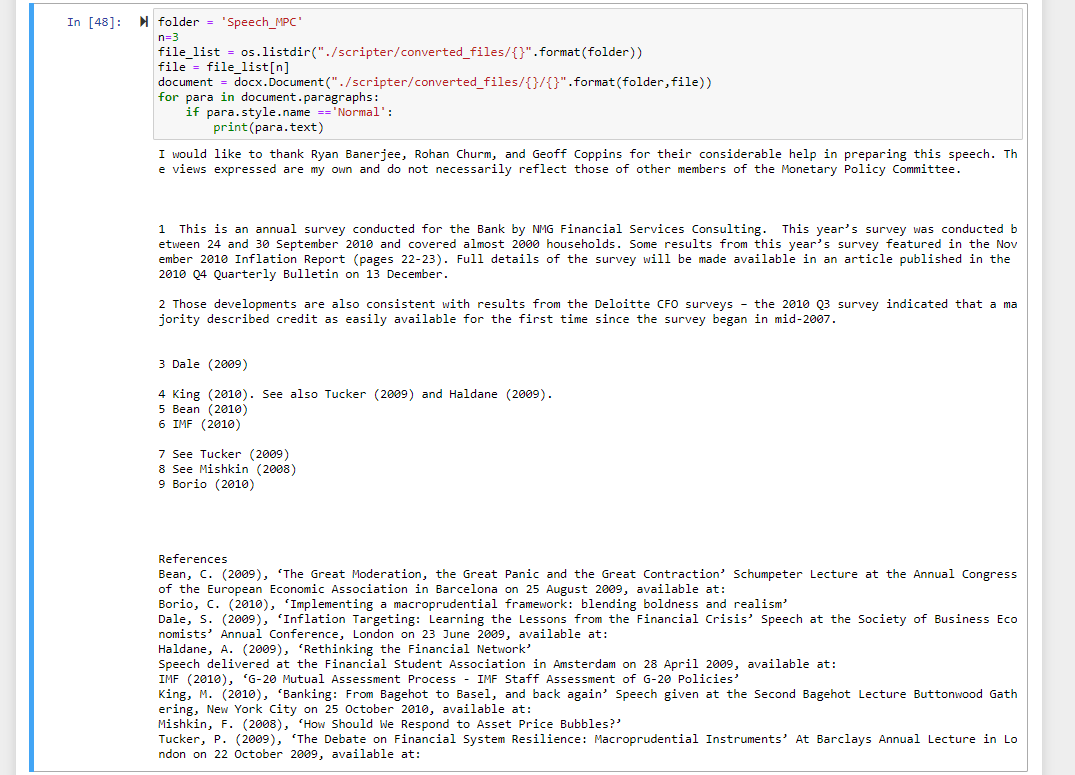

In [511]:
# MPC_speech.loc[:,'document_string'] = ''
# folder = 'Speech_MPC'
# file_list = os.listdir("./scripter/converted_files/{}".format(folder))
# for n,file in enumerate(file_list):
#     print('\r current file: {}/{}'.format(n,len(file_list)),end='')
#     file =file.replace('~$','[D').replace('[Disk','‘Risk')
#     document = docx.Document("./scripter/converted_files/{}/{}".format(folder,file))
#     Document_list = []   # each element represent one heading (section)
#     paragraph_list = ''  # each element represent one paragraph in each section
#     if_record = False
#     Set_start = True
#     empty_bodytext_count = 0
#     if sum(['Heading' in para.style.name for para in document.paragraphs])>=2:
#         for para in document.paragraphs:
#             if para.style.name !='Normal':
#                 if 'Heading' in para.style.name:
#                     if 'reference' in para.text.lower():
#                         if len(paragraph_list)>=10: Document_list.append(paragraph_list)
#                         paragraph_list = ''
#                         if_record = False
#                     elif 'chart' in para.text.lower() or 'tabel' in para.text.lower() or 'figure' in para.text.lower():
#                         pass
#                     else:
#                         if len(paragraph_list)>=10: Document_list.append(paragraph_list)
#                         paragraph_list = ''  # each element represent one paragraph in each section
#                         if_record = True      # skip the element in the first page
#                 elif para.style.name == 'List Paragraph' and if_record == False:
#                     paragraph_list = re.sub(r'[0-9]+', '',re.sub(r'[^\x00-\x7F]+',' ',para.text.replace('\uf0be','').replace('\t','').replace("\'","'")))
#                     if_record = True
#                 elif len(para.text.split())>=15 and if_record == True and not check_If_reference(para.text):
#                     paragraph_list = paragraph_list + ' ###newsubpoint### '+ re.sub(r'[0-9]+', '',re.sub(r'[^\x00-\x7F]+',' ', para.text.replace('\uf0be','').replace('\t','').replace("\'","'")))
#                 elif para.style.name == 'Body Text' and len(para.text)==0:
#                     empty_bodytext_count+=1
#                 else:
#                     pass

#             if empty_bodytext_count>=15 and Set_start == True: # a force start if there has been enough empty empty new rows
#                 if_record = True
#                 Set_start = False
#         Document_list.append(re.sub(r'[0-9]+', '',re.sub(r'[^\x00-\x7F]+',' ', paragraph_list.replace('\uf0be','').replace('\t',''))))    
#     else:
#         for para in document.paragraphs:
#             if para.style.name !='Normal' and para.text.count(' ')<=2:
#                 if 'appendix' in para.text.lower() or 'reference' in para.text.lower():
#                     break
#             if para.style.name !='Normal' and len(para.text.split())>=15 and not check_If_reference(para.text):
#                 Document_list.append(re.sub(r'[0-9]+', '',re.sub(r'[^\x00-\x7F]+',' ', para.text.replace('\uf0be','').replace('\t','').replace("\'","'")))) 
#     Document_list = [ i for i in Document_list if len(i)>=1]
#     if len(Document_list) == 1:
#         Document_list = [i for i in Document_list[0].split(' ###newsubpoint### ') if i!='']
#     else:
#         Document_list = [i.replace(' ###newsubpoint### ',' ') for i in Document_list]
#     Word_set = (' ###newline### ').join(Document_list)
#     MPC_speech.loc[MPC_speech['title']==file[:-5],'document_string'] = Word_set
#     text_file = open("./scripter/cleaned_dataset/{}/{}.txt".format(folder,file[:-5]), "w")
#     text_file.write(Word_set)
#     text_file.close()



 current file: 759/760

In [512]:
# file = 'Acceptance remarks on receiving the International Financial Law Reviews Regulatory Contribution Award.docx'
# document = docx.Document("./scripter/converted_files/{}/{}".format(folder,file))
# debug_print(document)

Heading 1
ACCEPTANCE REMARKS BY PAUL TUCKER ON RECEIVING THE INTERNATIONAL FINANCIAL LAW REVIEW’S REGULATORY CONTRIBUTION AWARD,
Body Text
(Collected on Paul Tucker’s behalf by Svein Andresen) Thank you very much to the IFLR.
Body Text
The greatest problem in international finance is Too Big To Fail. So long as it lies uncured, banking cannot assume its proper role at the heart of a market economy. Fortunately, a group of people – private sector as well as official sector – are determined to make distressed banks and dealers resolvable without taxpayer solvency support. That is what G20 Leaders have told us to do. Many people in this room are helping us get there. It will embarrass him to have to read this out but, through his role at the centre of the Financial Stability Board, Svein has been heroic in these efforts, and it is right that he collects this evening’s award. Eva Huepkes of FSB and Peter Brierley of the Bank of England also share the credit. But, truly, it is an endeavour 

In [5]:
# MPC_speech = load_up_from_cleaned_speech()

In [6]:
# MPC_speech.tag.unique()

array(['// Speech // Michael Saunders', '// Speech // Gertjan Vlieghe',
       '// Speech // Silvana Tenreyro', '// Speech // Mark Carney',
       '// Speech // Ben Broadbent', '// Speech // Jon Cunliffe',
       '// Speech // Jonathan Haskel', '// Speech // Dave Ramsden',
       '// Speech // Andy Haldane', '// Speech // Ian McCafferty',
       '// Speech // Kristin Forbes', '// Speech // Minouche Shafik',
       '// Speech // Martin Weale', '// Speech // David Miles',
       '// Speech', '// Speech // Monetary policy',
       '// Speech // Paul Fisher', '// Speech // Spencer Dale',
       '// Speech // Charles Bean', '// Speech // Paul Tucker',
       '// Speech // Mervyn King', '// Speech // Adam Posen',
       '// Speech // Speech', '// Speech // Andrew Sentance',
       '// Speech // Kate Barker', '// Speech // Timothy Besley',
       '// Speech // David Blanchflower', '// Speech // John Gieve',
       '// Speech // Rachel Lomax', '// Speech // Stephen Nickell',
       '// Speech 

#### Data Cleaning for MPC minutes

In [7]:
# MPC_minutes = pd.read_excel('./scripter/cleaned_dataset/MPC_minutes.xlsx')

In [95]:
# MPC_minutes.head()

,Unnamed: 0,title,link,date,tag,content,download,document_string
0,0,Bank Rate maintained at 01% - May 2020_1st,https://www.bankofengland.co.uk/monetary-polic...,07 May 2020,// News // Monetary Policy Committee (MPC),NaN,https://www.bankofengland.co.uk/-/media/boe/fi...,Monetary Policy Summary and minutes of the Mon...
1,1,Bank Rate maintained at 01% - March 2020_1st,https://www.bankofengland.co.uk/monetary-polic...,26 March 2020,// News // Monetary Policy Committee (MPC),NaN,https://www.bankofengland.co.uk/-/media/boe/fi...,Minutes of the special Monetary Policy Committ...
2,2,Minutes of the special Monetary Policy Committ...,https://www.bankofengland.co.uk/monetary-polic...,13 March 2020,// News // Monetary Policy Committee (MPC),NaN,https://www.bankofengland.co.uk/-/media/boe/fi...,Minutes of the special Monetary Policy Committ...
3,3,Bank Rate maintained at 075% - January 2020_1st,https://www.bankofengland.co.uk/monetary-polic...,30 January 2020,// News // Monetary Policy Committee (MPC),NaN,https://www.bankofengland.co.uk/-/media/boe/fi...,Monetary Policy Summary and minutes of the Mon...
4,4,Bank Rate maintained at 075% - December 2019_1st,https://www.bankofengland.co.uk/monetary-polic...,19 December 2019,// News // Monetary Policy Committee (MPC),NaN,https://www.bankofengland.co.uk/-/media/boe/fi...,Monetary Policy Summary and minutes of the Mon...


In this part, I have discarded the ANNEX part of the minutes as all the recent minutes no longer have that part.

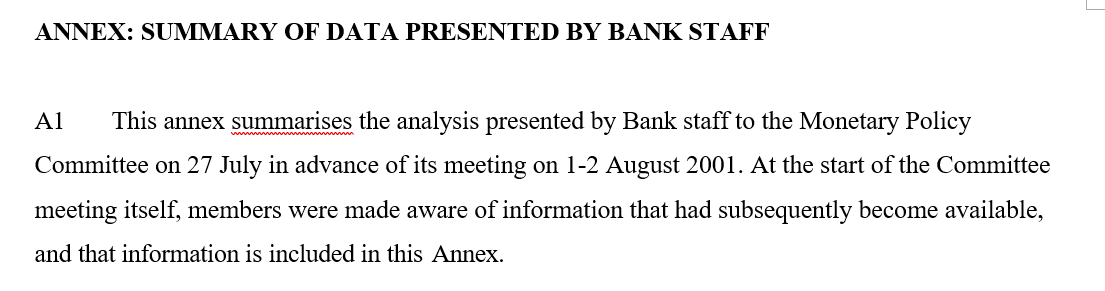

In [493]:
# # save to local
# folder ='Minutes_MPC'
# file_list = os.listdir("./scripter/converted_files/{}".format(folder))
# for n,file in enumerate(file_list):
#     print('\r Current on file {}/{}'.format(n+1,len(file_list)), end='')
#     Document_list = clean_text(file)
#     write_file(Document_list,folder,file)

 Current on file 266/266

(array([  5.,   0.,   0.,   4.,  87., 112.,  30.,  20.,   7.,   1.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

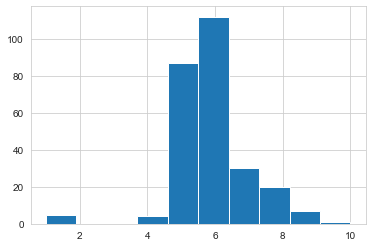

In [9]:
# MPC_minutes = load_up_from_cleaned_minutes()
# all_minutes_cleaned = list(MPC_minutes.document_string)
# all_minutes_cleaned = [decode_doc_minutes(i) for i in all_minutes_cleaned]
# MPC_minutes.loc[:,'N_topics'] = [len(decode_doc_minutes(i)) for i in MPC_minutes.document_string]
# plt.hist([len(i) for i in all_minutes_cleaned])

In [10]:
# # print and check the problem with few topics and too many topics 
# ranking_topics=list(zip(list(MPC_minutes.sort_values(by='N_topics', ascending=False).title),list(MPC_minutes.sort_values(by='N_topics', ascending=False).N_topics)))
# ranking_topics

[('Minutes of the MPC Meeting held on 3 and 4 May 2000_1st', 10),
 ('Minutes of the MPC Meeting held on 6 and 7 May 1998_1st', 9),
 ('Minutes of the MPC Meeting held on 5 and 6 August 1998_1st', 9),
 ('Bank Rate maintained at 01% - March 2020_1st', 9),
 ('Minutes of the MPC Meeting held on 9 and 10 December 1998_1st', 9),
 ('Minutes of the MPC Meeting held on 6 and 7 June 2000_1st', 9),
 ('Minutes of the MPC Meeting held on 4 and 5 March 1998_1st', 9),
 ('Minutes of the MPC Meeting held on 8 and 9 March 2000_1st', 9),
 ('Minutes of the MPC Meeting held on 31 July and 1 August 2002_1st', 8),
 ('Minutes of the MPC Meeting held on 3 and 4 November 1999_1st', 8),
 ('Minutes of the MPC Meeting held on 8 and 9 May 2002_1st', 8),
 ('Minutes of the MPC Meeting held on 9 and 10 February 2000_1st', 8),
 ('Minutes of the MPC Meeting held on 9 and 10 June 1999_1st', 8),
 ('Minutes of the MPC Meeting held on 5 and 6 April 2000_1st', 8),
 ('Minutes of the MPC Meeting held on 5 and 6 May 1999_1st', 8

**We discard the Monetary Policy Committee dates document which is useless to our project**

In [374]:
# additional_file = []
# for i in ranking_topics[:-5]:
#     file = '{}.docx'.format(i[0])
#     document = docx.Document("./scripter/converted_files/{}/{}".format(folder,file))
#     if 'policy decision' not in clean_text(file)[-1][0]:
#         additional_file.append(file)

In [375]:
# additional_file

['Minutes of the MPC Meeting held on 5 and 6 June 1997_1st.docx',
 'Minutes of the MPC Meeting held on 3 and 4 December 1997_1st.docx',
 'Minutes of the MPC Meeting held on 5 and 6 November 1997_1st.docx',
 'Minutes of the MPC Meeting held on 8 and 9 October 1997_1st.docx',
 'Minutes of the MPC Meeting held on 10 and 11 September 1997_1st.docx',
 'Minutes of the MPC Meeting held on 5 and 6 May 2004_1st.docx',
 'Minutes of the MPC Meeting held on 6 and 7 August 1997_1st.docx',
 'Minutes of the MPC Meeting held on 9 and 10 July 1997_1st.docx',
 'Minutes of the MPC Meeting held on 4 and 5 February 1998_1st.docx']

In [494]:
# file = 'Minutes of the MPC Meeting held on 5 and 6 November 1997_1st.docx'
# Document_list = clean_text(file)[1:]
# Document_list[-1][0] = 'The immediate policy decision'
# write_file(Document_list,folder,file)

# file = 'Minutes of the MPC Meeting held on 9 and 10 June 1999_1st.docx'
# Document_list = clean_text(file)
# write_file(Document_list,folder,file)

# file ='Minutes of the MPC Meeting held on 5 and 6 June 1997_1st.docx'
# Document_list = clean_text(file)[:-2]
# Document_list[-1][0] = 'The immediate policy decision'
# write_file(Document_list,folder,file)



# file = 'Minutes of the MPC Meeting held on 5 and 6 May 2004_1st.docx'
# Document_list = clean_text(file)
# Document_list[-1][0] = 'The immediate policy decision'
# write_file(Document_list,folder,file)

# file = 'Minutes of the MPC Meeting held on 3 and 4 December 1997_1st.docx'
# Document_list = clean_text(file)[1:]
# Document_list[-1][0] = 'The immediate policy decision'
# write_file(Document_list,folder,file)

# file =  'Minutes of the MPC Meeting held on 8 and 9 October 1997_1st.docx'
# Document_list = clean_text(file)[1:]
# Document_list[-1][0] = 'The immediate policy decision'
# write_file(Document_list,folder,file)

# file =  'Minutes of the MPC Meeting held on 10 and 11 September 1997_1st.docx'
# Document_list = clean_text(file)[1:]
# Document_list[-1][0] = 'The immediate policy decision'
# write_file(Document_list,folder,file)

# file = 'Minutes of the MPC Meeting held on 9 and 10 July 1997_1st.docx'
# Document_list = clean_text(file)
# Document_list[-1][0] = 'The immediate policy decision'
# write_file(Document_list,folder,file)


# file = 'Minutes of the MPC Meeting held on 6 and 7 August 1997_1st.docx'
# Document_list = clean_text(file)
# Document_list[-1][0] = 'The immediate policy decision'
# write_file(Document_list,folder,file)

# file = 'Minutes of the MPC Meeting held on 4 and 5 February 1998_1st.docx'
# Document_list = clean_text(file)[1:]
# Document_list[-1][0] = 'The immediate policy decision'
# write_file(Document_list,folder,file)

# Start from here for LDA models

In [12]:
black_list = ['These are the minutes of the special Monetary Policy Committee meeting held on 8 October 2008.',
             'MINUTES OF THE SPECIAL MONETARY POLICY COMMITTEE MEETING HELD ON 18 SEPTEMBER 2001',
             'These are the Minutes of the special Monetary Policy Committee meeting held on 18 September 2001.',
             'Minutes of the special Monetary Policy Committee meeting on 19 March 2020 and the Monetary Policy Committee meeting ending on 25 March 2020']
MPC_minutes = load_up_from_cleaned_minutes()
MPC_minutes.loc[:,'N_topics'] = [len(decode_doc_minutes(i)) for i in MPC_minutes.document_string]
MPC_minutes_reduced = MPC_minutes.loc[MPC_minutes['N_topics']>=2,:]

all_minutes_cleaned = list(MPC_minutes_reduced.document_string)
all_minutes_cleaned = [decode_doc_minutes(i) for i in all_minutes_cleaned]
show_section_name(all_minutes_cleaned)#(document_list)


[['Monetary Policy Summary, May 2020',
  'The international economy',
  'Financial markets',
  'Credit conditions and monetary developments',
  'Demand and output',
  'Supply, costs and prices',
  'The immediate policy decision'],
 ['Monetary Policy Summary, Monetary Policy Committee meeting ending on 25 March 2020',
  'What public policy is doing',
  'The role of monetary policy',
  'What the MPC is doing',
  'Minutes of the special Monetary Policy Committee meeting on 19 March 2020 and the Monetary Policy Committee meeting ending on 25 March 2020',
  'Data covering the period prior to the escalation of the spread of Covid-19',
  'Economic channels and impacts related to the spread of Covid-19',
  'Recent developments',
  'The immediate policy decisions'],
 ['Monetary and financial conditions',
  'The international economy',
  'Current economic conditions',
  'The immediate policy decision'],
 ['Monetary Policy Summary, January 2020',
  'Monetary and financial conditions',
  'The inte

In [13]:
def section_replace_rule(string1):
    if 'monetary policy summary,' in string1.lower():
        return 'Monetary Policy Summary'
    elif 'growth and inflation projections' in  string1.lower() or 'inflation and growth projections'in  string1.lower() :
        return 'Growth and inflation projections'
    elif 'summary' in  string1.lower():
        return 'Monetary Policy Summary'
    elif 'world economy' in string1.lower():
        return 'The international economy'
    elif 'considerations' in string1.lower():
        return 'Other considerations'
    else:
        return string1
    
change_dict={
    'World economy developments':'The international economy',
    'Demand, output, money and credit':'Money, credit, demand and output',
    'Demand and Output' : 'Demand and output',
    'Demand and output in the United Kingdom':'Demand and output',
    'The labour market':'Labour market',
    'The labour market, costs and prices':'Labour market',
    'The labour market, prices and costs':'Labour market',
    'Labour Market':'Labour market',
    'Labour market conditions':'Labour market',
    'Labour market developments':'Labour market',
    'The international environment':'The international economy',
    'The international environment: activity':'The international economy',
    'The international environment: prices':'The international economy',
    'The immediate policy decisions':'The immediate policy decision',
    'Domestic demand':'Demand',
    'Domestic demand, output and unemployment':'Demand and output',
    'Domestic demand: household balance sheets and consumption':'Demand', 
     'Money':'Money and credit',
     'Money and asset prices':'Money and credit',
     'Money and credit':'Money and credit',
     'Money and financial markets':'Money and credit',
     'Money, credit and asset prices':'Money and credit',
     'Money, credit and financial market prices':'Money and credit',
     'Money, credit and the exchange rate':'Money and credit',
    'Financial market developments':'Financial markets',
    'Monetary and financial conditions':'Financial markets',
    'The world economic outlook':'The international economy',
    'The prospects for global activity and prices':'The international economy',
}


'''
the aim is for the 6 most dominated sections:
'Monetary Policy Summary',
'Financial markets',
'The international economy',
'Money, credit, demand and output',
'Supply, costs and prices',
'The immediate policy decision'
'''


all_minutes_cleaned = [[[section_replace_rule(k[0])]+k[1:] for k in i if k[0] not in black_list
] for i in all_minutes_cleaned]
document_list = rule_for_replace(change_dict,all_minutes_cleaned)
document_list = rule_for_merge(['Monetary conditions','Credit conditions and monetary developments','Demand and output','Money and credit','Demand','Consumption','Credit, demand and output'],'Money, credit, demand and output',document_list)
document_list = rule_for_merge(['Labour market','Prices and costs','Commodity prices','Net trade','Costs and prices','Wages, costs and prices','Prices'],'Supply, costs and prices',document_list)



In [8]:
interested_topic = ['The immediate policy decision','Supply, costs and prices','Money, credit, demand and output',
        'The international economy','Financial markets','Growth and inflation projections','Other considerations']  

topic_type = []
para_string = []
for doc in document_list:
    for para in doc:
        if para[0] in interested_topic:
            for item in para[1:]:
                topic_type.append(para[0])
                para_string.append(item)

LDA_dataset = pd.DataFrame(data = {'type':topic_type,'string':para_string})
LDA_dataset.loc[:,'cleaned'] = preprocess_data(LDA_dataset.string)

In [9]:
LDA_dataset.loc[:,'cleaned']

0        [econom, data, consist, sudden, mark, drop, gl...
1        [accord, preliminari, flash, estim, euro, area...
2        [sinc, mpc, previou, meet, european, council, ...
3        [accord, advanc, estim, u, gdp, declin, q, per...
4        [end, march, u, govern, pas, coronaviru, aid, ...
                               ...                        
11241    [though, contrast, price, export, eu, non, eu,...
11242    [manufactur, input, price, fell, april, year, ...
11243    [twelv, month, rpix, inflat, fell, third, cons...
11244    [uk, continu, contrast, good, servic, inflat, ...
11245    [although, manufactur, output, price, flat, ma...
Name: cleaned, Length: 11246, dtype: object

In [123]:
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora
import multiprocessing
num_cores = multiprocessing.cpu_count() 





'''
All the text documents combined is known as the corpus. To run any mathematical model on text corpus, it is a good practice to convert it into a matrix representation. LDA model looks for repeating term patterns in the entire DT matrix. Python provides many great libraries for text mining practices, “gensim” is one such clean and beautiful library to handle text data. It is scalable, robust and efficient. Following code shows how to convert a corpus into a document-term matrix.
'''
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix
def topic_assignment(model,corps):
    a = model.get_document_topics(corps)
    a.sort(key=lambda x:-x[1])
    return a[0][0]

In [31]:
BOE_dictionary, BOE_corpus =  prepare_corpus(LDA_dataset.loc[:,'cleaned'])


tfidf = TfidfModel(BOE_corpus)
corpus_tfidf = tfidf[BOE_corpus]


tweets_lda = LdaMulticore(corpus=corpus_tfidf, num_topics = 7, id2word = BOE_dictionary, passes=10,workers=num_cores-1)
top_words = [[word for word,_ in tweets_lda.show_topic(topic_id, topn=10)] for topic_id in range(tweets_lda.num_topics)]
top_betas = [[beta for _,beta in tweets_lda.show_topic(topic_id, topn=10)] for topic_id in range(tweets_lda.num_topics)]



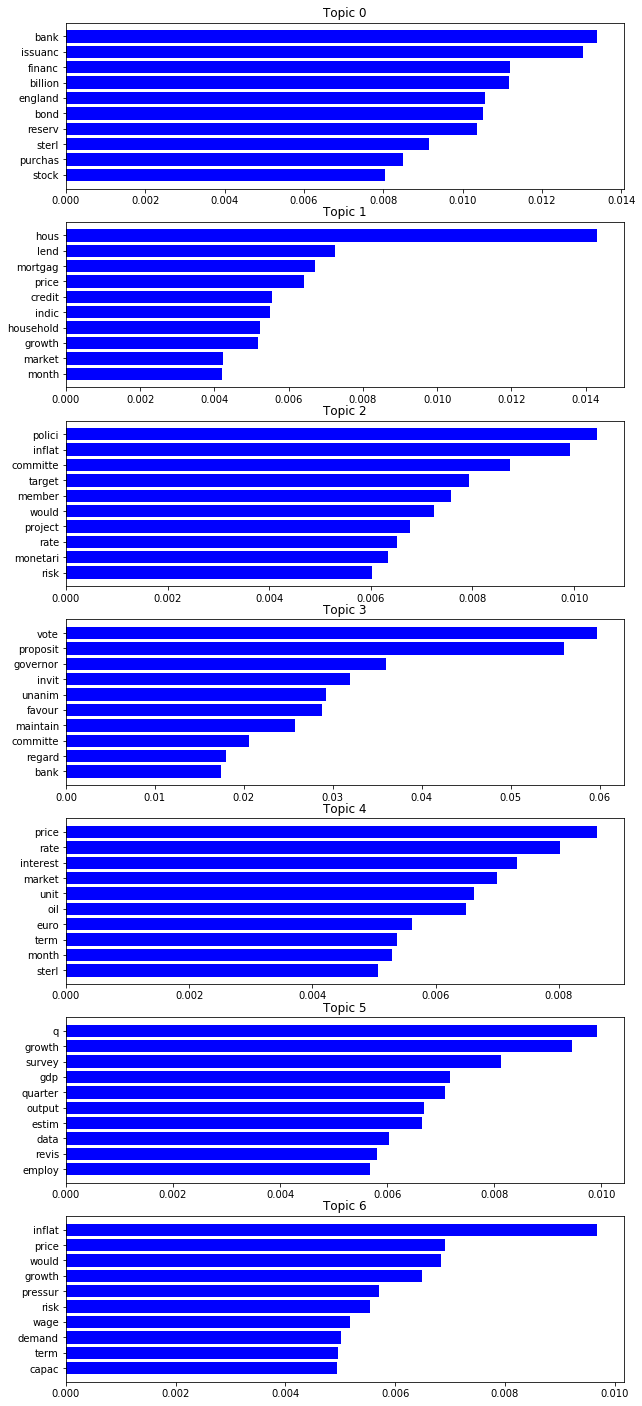

In [32]:
plt.figure(figsize=(10,25))
for i in range(7):
    ax = plt.subplot(7,1,i+1)
    plt.barh(range(10), top_betas[i][:10], align='center',color='blue', ecolor='black')
    ax.invert_yaxis()
    ax.set_yticks(range(10))
    ax.set_yticklabels(top_words[i][:10])
    plt.title("Topic "+str(i))

In [62]:
def topic_assignment(model,corps):
    a = model.get_document_topics(corps)
    a.sort(key=lambda x:-x[1])
    return a[0][0]

assignment_list=[]
for n in range(len(LDA_dataset)):
    assignment_list.append(topic_assignment(tweets_lda,corpus_tfidf[n]))
LDA_dataset.loc[:,'LDA_topic'] = assignment_list

In [63]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
LDA_dataset.loc[:,'type_int'] = LDA_dataset.loc[:,'type'].astype('category').cat.codes
cnf_matrix = confusion_matrix(LDA_dataset.type_int, LDA_dataset.LDA_topic)
np.set_printoptions(precision=2)


In [64]:
cnf_matrix

array([[ 278,   53,   82,    1,  806,    9,   25],
       [   0,    3,  123,    0,    4,   18,  211],
       [  72,  566,   97,    2,  172, 1143,  253],
       [   0,    2,   77,    0,   44,    4,   10],
       [  12,   15,   75,    0,  109, 1158,  507],
       [ 256,   59, 1206,  544,  254,  280, 1007],
       [  59,  144,   80,    0,  503,  673,  250]], dtype=int64)

 We could see the LDA classification is not as accurate as we thought and the clssification of minutes is not consistent.
 
 ### Now, I try to classfify scattered topics into the 6 big buskets.


In [7]:
interested_topic = ['The immediate policy decision','Supply, costs and prices','Money, credit, demand and output',
        'The international economy','Financial markets','Growth and inflation projections']  

topic_type = []
para_string = []
for doc in document_list:
    for para in doc:
        if para[0] not in interested_topic:
            for item in para[1:]:
                topic_type.append(para[0])
                para_string.append(item)
LDA_dataset_uncovered = pd.DataFrame(data = {'type':topic_type,'string':para_string})


topic_type = []
para_string = []
for doc in document_list:
    for para in doc:
        if para[0] in interested_topic:
            for item in para[1:]:
                topic_type.append(para[0])
                para_string.append(item)
LDA_dataset_covered = pd.DataFrame(data = {'type':topic_type,'string':para_string})

In [11]:
LDA_dataset_uncovered.loc[:,'cleaned'] = preprocess_data(LDA_dataset_uncovered.string)
LDA_dataset_uncovered

,type,string,cleaned
0,Monetary Policy Summary,Authorities around the world are taking action...,"[author, around, world, take, action, halt, sp..."
1,Monetary Policy Summary,The Bank of England s Monetary Policy Committe...,"[bank, england, monetari, polici, committe, mp..."
2,Monetary Policy Summary,non-financial investment-grade corporate bond ...,"[non, financi, invest, grade, corpor, bond, pu..."
3,Monetary Policy Summary,The spread of Covid- and the measures to conta...,"[spread, covid, measur, contain, signific, imp..."
4,Monetary Policy Summary,Economic data have continued to be consistent ...,"[econom, data, continu, consist, sudden, mark,..."
...,...,...,...
1041,Monetary Policy Summary,The estimated change in notes and coin in May ...,"[estim, chang, note, coin, may, revis, upward,..."
1042,Monetary Policy Summary,Broad money growth was unusually low in April:...,"[broad, money, growth, unusu, low, april, revi..."
1043,Monetary Policy Summary,Strong lending growth was continuing: the incr...,"[strong, lend, growth, continu, increas, total..."
1044,Monetary Policy Summary,Lending to persons also remained strong. Unsec...,"[lend, person, also, remain, strong, unsecur, ..."


In [75]:
BOE_dictionary, BOE_corpus =  prepare_corpus(LDA_dataset_uncovered.loc[:,'cleaned'])
tfidf = TfidfModel(BOE_corpus)
corpus_tfidf = tfidf[BOE_corpus]
# BOE_lda = LdaMulticore(corpus=corpus_tfidf, num_topics = 6, id2word = BOE_dictionary, passes=10,workers=num_cores-1)
# BOE_lda.save('.\Dictionary_based_method\lda_minutes.model')    

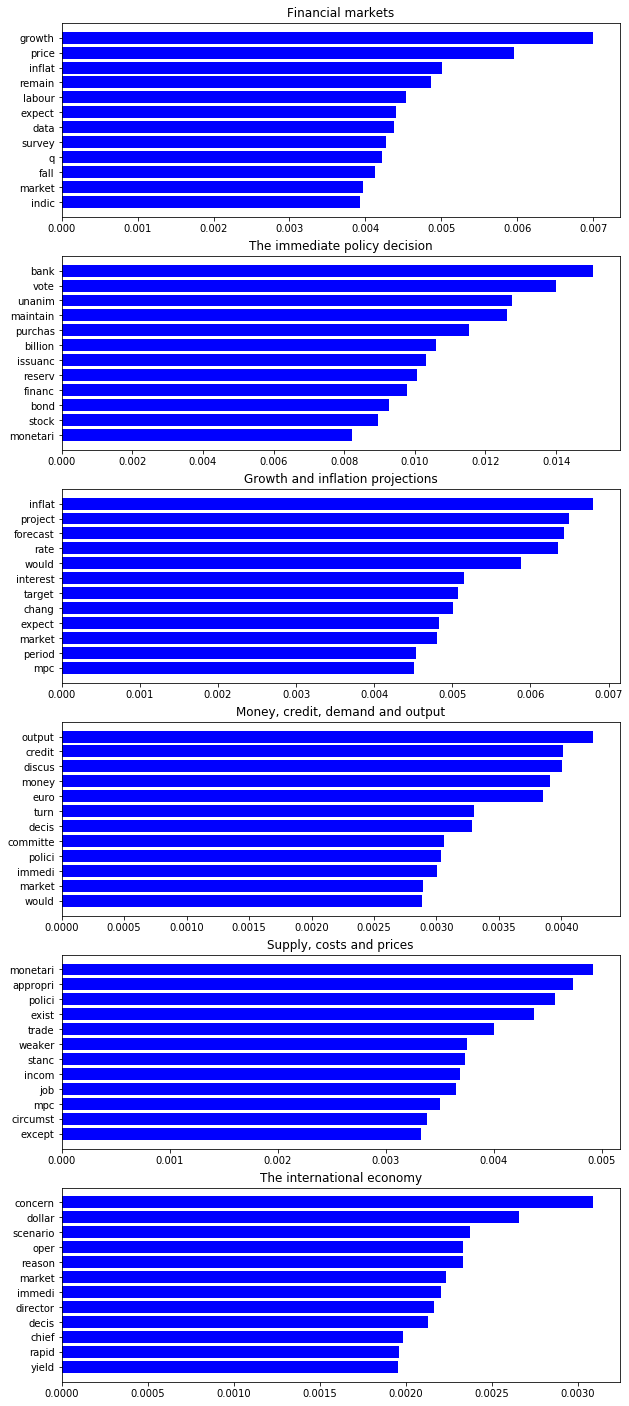

In [81]:
model_2 =  LdaMulticore.load('.\Dictionary_based_method\lda_minutes.model')
top_words = [[word for word,_ in model_2.show_topic(topic_id, topn=12)] for topic_id in range(model_2.num_topics)]
top_betas = [[beta for _,beta in model_2.show_topic(topic_id, topn=12)] for topic_id in range(model_2.num_topics)]
topics =[
    'Financial markets',
    'The immediate policy decision',
    'Growth and inflation projections',
    'Money, credit, demand and output',
    'Supply, costs and prices',
    'The international economy',  
]
plt.figure(figsize=(10,25))
for i in range(6):
    ax = plt.subplot(6,1,i+1)
    plt.barh(range(12), top_betas[i][:12], align='center',color='blue', ecolor='black')
    ax.invert_yaxis()
    ax.set_yticks(range(12))
    ax.set_yticklabels(top_words[i][:12])
    plt.title(topics[i])

In [99]:
assignment_list=[]
for n in range(len(LDA_dataset_uncovered)):
    assignment_list.append(topics[topic_assignment(model_2,corpus_tfidf[n])])
new_df = pd.DataFrame(data={'type':assignment_list,'string':LDA_dataset_uncovered.string})
new_df

,type,string
0,"Supply, costs and prices",Authorities around the world are taking action...
1,The immediate policy decision,The Bank of England s Monetary Policy Committe...
2,The immediate policy decision,non-financial investment-grade corporate bond ...
3,Financial markets,The spread of Covid- and the measures to conta...
4,Financial markets,Economic data have continued to be consistent ...
...,...,...
1041,Financial markets,The estimated change in notes and coin in May ...
1042,Financial markets,Broad money growth was unusually low in April:...
1043,Financial markets,Strong lending growth was continuing: the incr...
1044,Financial markets,Lending to persons also remained strong. Unsec...


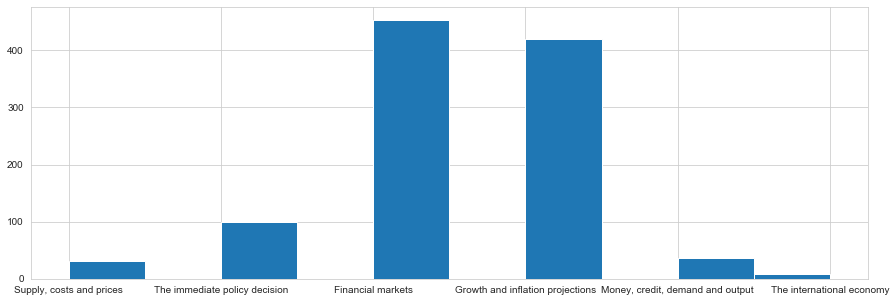

In [89]:
plt.figure(figsize=(15,5))
plt.hist(LDA_dataset_uncovered.LDA_topic)
plt.show()

In [119]:
new_document_list = document_list.copy()
for i,doc in enumerate(document_list):
    for j,para in enumerate(doc):
        if para[0] not in interested_topic:
            string = preprocess_data([' '.join(para[1:])])[0]
            string = BOE_dictionary.doc2bow(string)
            new_document_list[i][j][0] = topics[topic_assignment(model_2,string)]
show_unique_section_name(new_document_list)

{'Financial markets': 262,
 'The immediate policy decision': 262,
 'Supply, costs and prices': 253,
 'Money, credit, demand and output': 252,
 'The international economy': 245,
 'Growth and inflation projections': 183}

The grouping is much cleaner than previous.
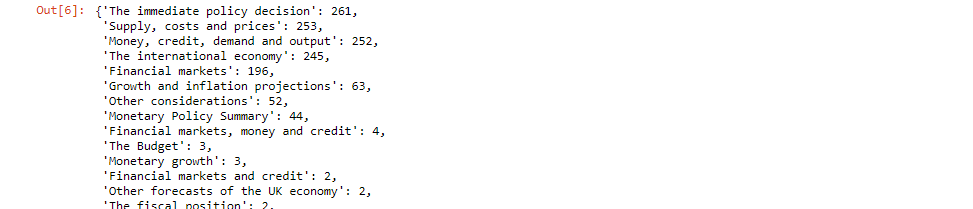

In [120]:
MPC_minutes_reduced.loc[:,'N_topics'] = new_document_list
MPC_minutes_reduced.to_hdf('data.h5', key='minutes', mode='w')

C:\Users\lunarhero\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\lunarhero\anaconda3\lib\site-packages\pandas\core\generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['title', 'link', 'date', 'tag', 'download', 'document_string',
       'N_topics'],
      dtype='object')]

  encoding=encoding,


____
----
----
### Stop here, all code below are experimental

In [63]:
black_list = ['These are the minutes of the special Monetary Policy Committee meeting held on 8 October 2008.',
             'MINUTES OF THE SPECIAL MONETARY POLICY COMMITTEE MEETING HELD ON 18 SEPTEMBER 2001',
             'These are the Minutes of the special Monetary Policy Committee meeting held on 18 September 2001.',
             'Minutes of the special Monetary Policy Committee meeting on 19 March 2020 and the Monetary Policy Committee meeting ending on 25 March 2020']
MPC_minutes = load_up_from_cleaned_minutes()
MPC_minutes.loc[:,'N_topics'] = [len(decode_doc_minutes(i)) for i in MPC_minutes.document_string]
MPC_minutes_reduced = MPC_minutes.loc[MPC_minutes['N_topics']>=2,:]


MPC_minutes_reduced.loc[:,'New_date'] = pd.to_datetime(MPC_minutes_reduced.loc[:,'date'])
MPC_minutes_reduced = MPC_minutes_reduced.loc[MPC_minutes_reduced.loc[:,'New_date']<='2009-12-31',:]


all_minutes_cleaned = list(MPC_minutes_reduced.document_string)
all_minutes_cleaned = [decode_doc_minutes(i) for i in all_minutes_cleaned]
show_section_name(all_minutes_cleaned)#(document_list)



def section_replace_rule(string1):
    if 'monetary policy summary,' in string1.lower():
        return 'Monetary Policy Summary'
    elif 'growth and inflation projections' in  string1.lower() or 'inflation and growth projections'in  string1.lower() :
        return 'Growth and inflation projections'
    elif 'summary' in  string1.lower():
        return 'Monetary Policy Summary'
    elif 'world economy' in string1.lower():
        return 'The international economy'
    elif 'considerations' in string1.lower():
        return 'Other considerations'
    else:
        return string1
    
change_dict={
    'World economy developments':'The international economy',
    'Demand, output, money and credit':'Money, credit, demand and output',
    'Demand and Output' : 'Demand and output',
    'Demand and output in the United Kingdom':'Demand and output',
    'The labour market':'Labour market',
    'The labour market, costs and prices':'Labour market',
    'The labour market, prices and costs':'Labour market',
    'Labour Market':'Labour market',
    'Labour market conditions':'Labour market',
    'Labour market developments':'Labour market',
    'The international environment':'The international economy',
    'The international environment: activity':'The international economy',
    'The international environment: prices':'The international economy',
    'The immediate policy decisions':'The immediate policy decision',
    'Domestic demand':'Demand',
    'Domestic demand, output and unemployment':'Demand and output',
    'Domestic demand: household balance sheets and consumption':'Demand', 
     'Money':'Money and credit',
     'Money and asset prices':'Money and credit',
     'Money and credit':'Money and credit',
     'Money and financial markets':'Money and credit',
     'Money, credit and asset prices':'Money and credit',
     'Money, credit and financial market prices':'Money and credit',
     'Money, credit and the exchange rate':'Money and credit',
    'Financial market developments':'Financial markets',
    'Monetary and financial conditions':'Financial markets',
    'The world economic outlook':'The international economy',
    'The prospects for global activity and prices':'The international economy',
}


'''
the aim is for the 6 most dominated sections:
'Monetary Policy Summary',
'Financial markets',
'The international economy',
'Money, credit, demand and output',
'Supply, costs and prices',
'The immediate policy decision'
'''


all_minutes_cleaned = [[[section_replace_rule(k[0])]+k[1:] for k in i if k[0] not in black_list
] for i in all_minutes_cleaned]
document_list = rule_for_replace(change_dict,all_minutes_cleaned)
document_list = rule_for_merge(['Monetary conditions','Credit conditions and monetary developments','Demand and output','Money and credit','Demand','Consumption','Credit, demand and output'],'Money, credit, demand and output',document_list)
document_list = rule_for_merge(['Labour market','Prices and costs','Commodity prices','Net trade','Costs and prices','Wages, costs and prices','Prices'],'Supply, costs and prices',document_list)

from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora
import multiprocessing
num_cores = multiprocessing.cpu_count() 





'''
All the text documents combined is known as the corpus. To run any mathematical model on text corpus, it is a good practice to convert it into a matrix representation. LDA model looks for repeating term patterns in the entire DT matrix. Python provides many great libraries for text mining practices, “gensim” is one such clean and beautiful library to handle text data. It is scalable, robust and efficient. Following code shows how to convert a corpus into a document-term matrix.
'''
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix
def topic_assignment(model,corps):
    a = model.get_document_topics(corps)
    a.sort(key=lambda x:-x[1])
    return a[0][0]

interested_topic = ['The immediate policy decision','Supply, costs and prices','Money, credit, demand and output',
        'The international economy','Financial markets','Growth and inflation projections']  

topic_type = []
para_string = []
for doc in document_list:
    for para in doc:
        if para[0] not in interested_topic:
            for item in para[1:]:
                topic_type.append(para[0])
                para_string.append(item)
LDA_dataset_uncovered = pd.DataFrame(data = {'type':topic_type,'string':para_string})


topic_type = []
para_string = []
for doc in document_list:
    for para in doc:
        if para[0] in interested_topic:
            for item in para[1:]:
                topic_type.append(para[0])
                para_string.append(item)
LDA_dataset_covered = pd.DataFrame(data = {'type':topic_type,'string':para_string})
LDA_dataset_uncovered.loc[:,'cleaned'] = preprocess_data(LDA_dataset_uncovered.string)

BOE_dictionary, BOE_corpus =  prepare_corpus(LDA_dataset_uncovered.loc[:,'cleaned'])
tfidf = TfidfModel(BOE_corpus)
corpus_tfidf = tfidf[BOE_corpus]
   

C:\Users\lunarhero\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\lunarhero\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


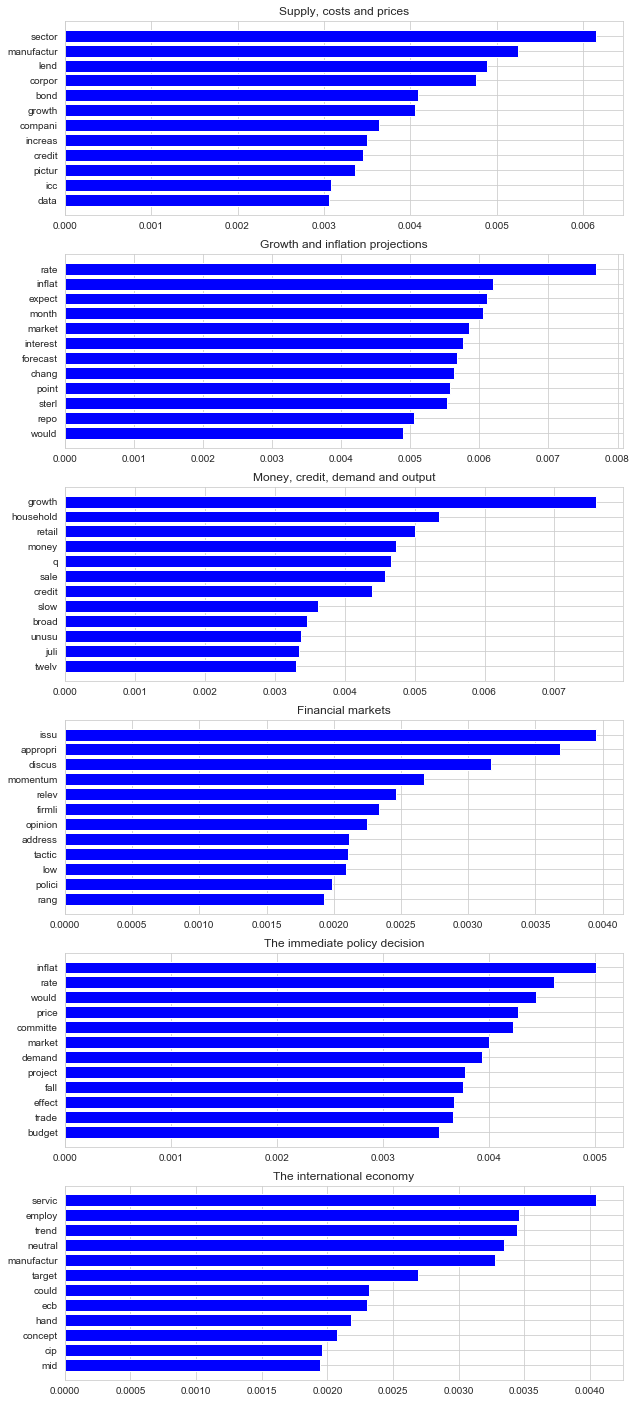

In [43]:
# BOE_lda = LdaMulticore(corpus=corpus_tfidf, num_topics = 6, id2word = BOE_dictionary, passes=10,workers=num_cores-1)
# BOE_lda.save('.\Dictionary_based_method\lda_minutes_until_2009.model') 
# model_2 =  LdaMulticore.load('.\Dictionary_based_method\lda_minutes_until_2009.model')
top_words = [[word for word,_ in model_2.show_topic(topic_id, topn=12)] for topic_id in range(model_2.num_topics)]
top_betas = [[beta for _,beta in model_2.show_topic(topic_id, topn=12)] for topic_id in range(model_2.num_topics)]
topics =[
    'Supply, costs and prices',
    'Growth and inflation projections',
    'Money, credit, demand and output',
    'Financial markets',
    'The immediate policy decision',
    'The international economy', 
]
plt.figure(figsize=(10,25))
for i in range(6):
    ax = plt.subplot(6,1,i+1)
    plt.barh(range(12), top_betas[i][:12], align='center',color='blue', ecolor='black')
    ax.invert_yaxis()
    ax.set_yticks(range(12))
    ax.set_yticklabels(top_words[i][:12])
    plt.title(topics[i])

In [73]:
MPC_minutes = load_up_from_cleaned_minutes()
MPC_minutes.loc[:,'N_topics'] = [len(decode_doc_minutes(i)) for i in MPC_minutes.document_string]
MPC_minutes_reduced = MPC_minutes.loc[MPC_minutes['N_topics']>=2,:]


MPC_minutes_reduced.loc[:,'New_date'] = pd.to_datetime(MPC_minutes_reduced.loc[:,'date'])


all_minutes_cleaned = list(MPC_minutes_reduced.document_string)
all_minutes_cleaned = [decode_doc_minutes(i) for i in all_minutes_cleaned]

all_minutes_cleaned = [[[section_replace_rule(k[0])]+k[1:] for k in i if k[0] not in black_list
] for i in all_minutes_cleaned]
document_list = rule_for_replace(change_dict,all_minutes_cleaned)
document_list = rule_for_merge(['Monetary conditions','Credit conditions and monetary developments','Demand and output','Money and credit','Demand','Consumption','Credit, demand and output'],'Money, credit, demand and output',document_list)
document_list = rule_for_merge(['Labour market','Prices and costs','Commodity prices','Net trade','Costs and prices','Wages, costs and prices','Prices'],'Supply, costs and prices',document_list)

interested_topic = ['The immediate policy decision','Supply, costs and prices','Money, credit, demand and output',
        'The international economy','Financial markets','Growth and inflation projections']  

topic_type = []
para_string = []
for doc in document_list:
    for para in doc:
        if para[0] not in interested_topic:
            for item in para[1:]:
                topic_type.append(para[0])
                para_string.append(item)
LDA_dataset_uncovered = pd.DataFrame(data = {'type':topic_type,'string':para_string})


topic_type = []
para_string = []
for doc in document_list:
    for para in doc:
        if para[0] in interested_topic:
            for item in para[1:]:
                topic_type.append(para[0])
                para_string.append(item)
LDA_dataset_covered = pd.DataFrame(data = {'type':topic_type,'string':para_string})
LDA_dataset_uncovered.loc[:,'cleaned'] = preprocess_data(LDA_dataset_uncovered.string)

_, BOE_corpus =  prepare_corpus()


In [79]:
id2word = corpora.Dictionary.load('./Dictionary_based_method/lda_minutes_until_2009.model.id2word')


BOE_corpus = [id2word.doc2bow(doc) for doc in LDA_dataset_uncovered.loc[:,'cleaned']]
tfidf = TfidfModel(BOE_corpus,id2word= id2word)
corpus_tfidf = tfidf[BOE_corpus]


In [80]:
assignment_list=[]
for n in range(len(LDA_dataset_uncovered)):
    assignment_list.append(topics[topic_assignment(model_2,corpus_tfidf[n])])
    
new_df = pd.DataFrame(data={'type':assignment_list,'string':LDA_dataset_uncovered.string})
new_document_list = document_list.copy()
for i,doc in enumerate(document_list):
    for j,para in enumerate(doc):
        if para[0] not in interested_topic:
            string = preprocess_data([' '.join(para[1:])])[0]
            string = BOE_dictionary.doc2bow(string)
            new_document_list[i][j][0] = topics[topic_assignment(model_2,string)]
            
MPC_minutes_reduced.loc[:,'N_topics'] = new_document_list
MPC_minutes_reduced.to_hdf('data_trained_until_2009.h5', key='minutes', mode='w')

C:\Users\lunarhero\anaconda3\lib\site-packages\pandas\core\generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['title', 'link', 'date', 'tag', 'download', 'document_string',
       'N_topics'],
      dtype='object')]

  encoding=encoding,
